In [ ]:
# Import libararies
import os
import copy
import pandas as pd
import numpy as np
from collections import Counter
from datetime import date, timedelta
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing datasets
met_stations = pd.read_csv('/content/drive/MyDrive/FYP/met-stations.tsv',sep='\t',index_col=0)
met_forecast = pd.read_csv('/content/drive/MyDrive/FYP/met-forecast.tsv',sep='\t',index_col=0) 
rl_sites = pd.read_csv('/content/drive/MyDrive/FYP/rl-sites.tsv',sep='\t',index_col=0)
rl_kpis = pd.read_csv('/content/drive/MyDrive/FYP/rl-kpis.tsv',sep='\t',index_col=0)
distances = pd.read_csv('/content/drive/MyDrive/FYP/distances.tsv',sep='\t', index_col=0)
met_real = pd.read_csv('/content/drive/MyDrive/FYP/met-real.tsv', sep='\t',index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:

rl_kpis['datetime'] = [datetime.strptime(x.replace('-','/'),'%Y/%m/%d') for x in rl_kpis_mod['datetime']]
rl_kpis

,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf
0,ENK,2018-12-31,FAR,A0BE,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-31.0,456.0,1024QAM,False
1,ENK,2018-12-31,FAR,A0BI,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.7,456.0,1024QAM,False
2,ENK,2018-12-31,FAR,A5AB,"1,344,018",RL_;ABDV,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-34.4,406.0,512QAM,False
3,NEC,2018-12-31,FAR,A8CQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False
4,NEC,2018-12-31,FAR,A8DQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992981,NEC,2020-12-25,NEAR,A6FD,"1,371,370",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-36.8,495.0,2048QAM*,False
1992982,NEC,2020-12-25,NEAR,A6NA,"1,371,370",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-36.8,495.0,2048QAM*,False
1992983,NEC,2020-12-25,FAR,A8FJ,"1,371,440",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-28.9,495.0,2048QAM*,False
1992984,NEC,2020-12-25,FAR,A8HV,"1,371,440",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-28.9,495.0,2048QAM*,False


In [ ]:
met_stations.head()

,station_no,height,clutter_class
0,WS_17047,381,DENSE TREE
1,WS_17062,5,LOW-MEDIUM URBAN
2,WS_17063,99,AIRPORT
3,WS_17064,18,OPEN IN URBAN
4,WS_17065,123,LOW-SPARSE URBAN


In [ ]:
rl_kpis.head()

,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf
0,ENK,2018-12-31,FAR,A0BE,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-31.0,456.0,1024QAM,False
1,ENK,2018-12-31,FAR,A0BI,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.7,456.0,1024QAM,False
2,ENK,2018-12-31,FAR,A5AB,"1,344,018",RL_;ABDV,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-34.4,406.0,512QAM,False
3,NEC,2018-12-31,FAR,A8CQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False
4,NEC,2018-12-31,FAR,A8DQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False


In [ ]:
rl_kpis['adaptive_modulation'].value_counts()

Enable     1798492
Disable     194494
Name: adaptive_modulation, dtype: int64

In [ ]:
met_forecast.head()

,station_no,datetime,report_time,weather_day1,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day2,temp_max_day2,temp_min_day2,humidity_max_day2,humidity_min_day2,wind_dir_day2,wind_speed_day2,weather_day3,temp_max_day3,temp_min_day3,humidity_max_day3,humidity_min_day3,wind_dir_day3,wind_speed_day3,weather_day4,temp_max_day4,temp_min_day4,humidity_max_day4,humidity_min_day4,wind_dir_day4,wind_speed_day4,weather_day5,temp_max_day5,temp_min_day5,humidity_max_day5,humidity_min_day5,wind_dir_day5,wind_speed_day5
0,WS_17047,2018-01-02,evening,heavy rain,10,6,96.0,82.0,6.0,19.0,rain,9,5,96.0,78.0,5.0,18.0,overcast clouds,10,2,93.0,69.0,213.0,14.0,few clouds,12,4,92.0,57.0,185.0,12.0,few clouds,14,8,90.0,70.0,210.0,16.0
1,WS_17047,2018-01-02,morning,heavy rain,10,6,96.0,82.0,6.0,19.0,rain,9,5,96.0,78.0,5.0,18.0,overcast clouds,10,2,93.0,69.0,213.0,14.0,few clouds,12,4,92.0,57.0,185.0,12.0,few clouds,14,8,90.0,70.0,210.0,16.0
2,WS_17062,2018-01-02,evening,heavy rain,12,9,96.0,80.0,84.0,10.0,rain,12,8,96.0,80.0,24.0,14.0,overcast clouds,12,6,89.0,75.0,228.0,16.0,few clouds,14,7,86.0,57.0,114.0,10.0,few clouds,17,10,78.0,67.0,107.0,14.0
3,WS_17062,2018-01-02,morning,heavy rain,12,9,96.0,80.0,84.0,10.0,rain,12,8,96.0,80.0,24.0,14.0,overcast clouds,12,6,89.0,75.0,228.0,16.0,few clouds,14,7,86.0,57.0,114.0,10.0,few clouds,17,10,78.0,67.0,107.0,14.0
4,WS_17063,2018-01-02,evening,heavy rain,13,9,95.0,78.0,87.0,10.0,rain,13,7,95.0,75.0,27.0,14.0,overcast clouds,11,7,92.0,77.0,14.0,14.0,few clouds,14,6,86.0,57.0,134.0,11.0,few clouds,17,10,78.0,63.0,131.0,14.0


In [ ]:
rl_sites.head()

,site_id,groundheight,clutter_class
0,RL_;ABDV,107.9658,OPEN LAND
1,RL_;ABL>,97.9733,OPEN LAND
2,RL_;ABTP,3.0446,OPEN LAND
3,RL_;AC?E,85.0143,OPEN LAND
4,RL_;ADKP,192.9800,DENSE TREE


In [ ]:
# Station names
stations = met_stations['station_no'].tolist()

In [ ]:
# Forecast dates
forecast_dates = sorted(list(set(met_forecast['datetime'])))

In [ ]:
met_forecast.sort_values(by=['station_no', 'datetime']).head()

,station_no,datetime,report_time,weather_day1,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day2,temp_max_day2,temp_min_day2,humidity_max_day2,humidity_min_day2,wind_dir_day2,wind_speed_day2,weather_day3,temp_max_day3,temp_min_day3,humidity_max_day3,humidity_min_day3,wind_dir_day3,wind_speed_day3,weather_day4,temp_max_day4,temp_min_day4,humidity_max_day4,humidity_min_day4,wind_dir_day4,wind_speed_day4,weather_day5,temp_max_day5,temp_min_day5,humidity_max_day5,humidity_min_day5,wind_dir_day5,wind_speed_day5
0,WS_17047,2018-01-02,evening,heavy rain,10,6,96.0,82.0,6.0,19.0,rain,9,5,96.0,78.0,5.0,18.0,overcast clouds,10,2,93.0,69.0,213.0,14.0,few clouds,12,4,92.0,57.0,185.0,12.0,few clouds,14,8,90.0,70.0,210.0,16.0
1,WS_17047,2018-01-02,morning,heavy rain,10,6,96.0,82.0,6.0,19.0,rain,9,5,96.0,78.0,5.0,18.0,overcast clouds,10,2,93.0,69.0,213.0,14.0,few clouds,12,4,92.0,57.0,185.0,12.0,few clouds,14,8,90.0,70.0,210.0,16.0
20,WS_17047,2018-01-03,evening,light rain,9,4,96.0,85.0,6.0,19.0,scattered clouds,9,3,92.0,59.0,5.0,19.0,few clouds,10,2,95.0,65.0,194.0,11.0,clear sky,13,5,91.0,67.0,210.0,16.0,clear sky,14,8,94.0,78.0,211.0,16.0
21,WS_17047,2018-01-03,morning,light rain,9,4,96.0,85.0,6.0,19.0,scattered clouds,9,3,92.0,59.0,5.0,19.0,few clouds,10,2,95.0,65.0,194.0,11.0,clear sky,13,5,91.0,67.0,210.0,16.0,clear sky,14,8,94.0,78.0,211.0,16.0
40,WS_17047,2018-01-04,evening,scattered clouds,9,4,91.0,60.0,0.0,16.0,few clouds,10,3,96.0,66.0,190.0,9.0,foggy,12,5,93.0,63.0,207.0,14.0,foggy,13,7,93.0,76.0,216.0,15.0,foggy,12,9,96.0,81.0,213.0,22.0


In [ ]:
to_drop = [c for c in met_forecast.columns 
           if ('day1' not in c) and (c not in ['station_no', 'datetime', 'report_time'])]
met_forecast_v2 = met_forecast.drop(columns=to_drop)
met_forecast_v2.head()

,station_no,datetime,report_time,weather_day1,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1
0,WS_17047,2018-01-02,evening,heavy rain,10,6,96.0,82.0,6.0,19.0
1,WS_17047,2018-01-02,morning,heavy rain,10,6,96.0,82.0,6.0,19.0
2,WS_17062,2018-01-02,evening,heavy rain,12,9,96.0,80.0,84.0,10.0
3,WS_17062,2018-01-02,morning,heavy rain,12,9,96.0,80.0,84.0,10.0
4,WS_17063,2018-01-02,evening,heavy rain,13,9,95.0,78.0,87.0,10.0


In [ ]:
mean_values = met_forecast_v2.groupby(by=['station_no', 'datetime']).mean().reset_index()
mean_values.sort_values(by=['station_no', 'datetime']).head()

,station_no,datetime,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1
0,WS_17047,2018-01-02,10.0,6.0,96.0,82.0,6.0,19.0
1,WS_17047,2018-01-03,9.0,4.0,96.0,85.0,6.0,19.0
2,WS_17047,2018-01-04,9.0,4.0,91.0,60.0,0.0,16.0
3,WS_17047,2018-01-05,10.0,3.0,96.0,70.0,194.0,9.0
4,WS_17047,2018-01-06,11.0,4.0,96.0,63.0,209.0,14.0


**Categorical data**

In [ ]:
numerical_values = met_forecast_v2.describe().columns
non_num_df = met_forecast_v2[[x for x in met_forecast_v2.columns 
                              if x not in numerical_values]]
non_num_df.head()

,station_no,datetime,report_time,weather_day1
0,WS_17047,2018-01-02,evening,heavy rain
1,WS_17047,2018-01-02,morning,heavy rain
2,WS_17062,2018-01-02,evening,heavy rain
3,WS_17062,2018-01-02,morning,heavy rain
4,WS_17063,2018-01-02,evening,heavy rain


In [ ]:
# 'Report_time' will be dropped
ohe_df = copy.deepcopy(non_num_df[['station_no', 'datetime']])
for x in range(1):
  temp = pd.get_dummies(non_num_df[f'weather_day{x+1}'], prefix=f'wd{x+1}')
  ohe_df = pd.concat([ohe_df, temp], axis=1)
ohe_df.head()

,station_no,datetime,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,wd1_thunderstorm with heavy rain,wd1_windy
0,WS_17047,2018-01-02,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,WS_17047,2018-01-02,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,WS_17062,2018-01-02,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,WS_17062,2018-01-02,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,WS_17063,2018-01-02,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Dealing with two datetimes
ohe_df = ohe_df.groupby(by=['station_no', 'datetime'], as_index=False).agg(lambda x: 1 if sum(x) > 1 else sum(x))
ohe_df.head()

,station_no,datetime,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,wd1_thunderstorm with heavy rain,wd1_windy
0,WS_17047,2018-01-02,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,WS_17047,2018-01-03,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,WS_17047,2018-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,WS_17047,2018-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,WS_17047,2018-01-06,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Combining the numerical data with the categorical**

In [ ]:
modified_forecast_df = pd.merge(left=mean_values, right=ohe_df, on=['station_no', 'datetime'])
modified_forecast_df.head()

,station_no,datetime,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,wd1_thunderstorm with heavy rain,wd1_windy
0,WS_17047,2018-01-02,10.0,6.0,96.0,82.0,6.0,19.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,WS_17047,2018-01-03,9.0,4.0,96.0,85.0,6.0,19.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,WS_17047,2018-01-04,9.0,4.0,91.0,60.0,0.0,16.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,WS_17047,2018-01-05,10.0,3.0,96.0,70.0,194.0,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,WS_17047,2018-01-06,11.0,4.0,96.0,63.0,209.0,14.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


On RL KPIS
-> Using modified data  \
-> Adding the forecast information from the nearest weather stations (from the previous day)\
-> Adding the KPI information from the previous day.

In [ ]:
distances

,WS_19111,WS_17047,WS_18397,WS_17062,WS_17813,WS_17064,WS_19112,WS_17063,WS_18736,WS_17065,WS_18399,WS_17610,WS_18792,WS_18735,WS_18100,WS_17437,WS_17448,WS_18403,WS_18404,WS_17389,RL_U7MPL,RL_X;ORF,RL_X;OE?,RL_\K[RM,RL_UBUGK,RL_X;OQA,RL_\K[LJ,RL_L=SKK,RL_\K[QH,RL_\K[EJ,RL_\K[EH,RL_KMLM0,RL_KMBTO,RL_KMPPE,RL_[EDCP,RL_K=LMV,RL_SEI?I,RL_IBLMM,RL_JETKO,RL_b;ZI>,...,RL_[KBQ>,RL_S7EPE,RL_P7ZEQ,RL_S7ECS,RL_JETRB,RL_S7EA>,RL_UBUQQ,RL_S7EWB,RL_S7EL>,RL_SKDRB,RL_I9UCH,RL_K7EKV,RL_\;EFV,RL_S?[@@,RL_POOSQ,RL_JETQ@,RL_I9JER,RL_UENSQ,RL_SE[Q@,RL_\;EDF,RL_SHUIL,RL_N8BJ>,RL_[7TIQ,RL_U?OCQ,RL_X;O@Q,RL_SHU@L,RL_S:ISI,RL_J7DG?,RL_JET@P,RL_N;OEL,RL_]=UC>,RL_]ITCK,RL_[KBDF,RL_X;O@O,RL_b?LMI,RL_]IC?O,RL_S:PQD,RL_JEZWL,RL_LKEII,RL_[EOMJ
WS_19111,0.00000,18.65248,60.37075,41.38519,44.21637,53.29280,57.28976,63.45174,62.78558,54.45858,58.62208,79.43958,78.35707,96.01031,65.61676,63.28520,66.61600,48.13006,41.71827,39.38671,50.96124,63.36847,72.61144,68.53121,51.29432,59.53805,70.86277,85.26848,65.94984,63.78482,64.86733,45.29888,40.55249,66.11638,42.13462,42.30116,47.21409,41.88481,47.79698,40.80230,...,46.29812,41.55173,40.96884,42.46770,47.88025,41.63500,51.29432,41.71827,41.80154,48.29660,42.63424,44.88253,40.80230,43.13386,40.88557,48.29660,42.55097,41.63500,46.96428,40.80230,56.29052,43.88329,45.88177,45.54869,59.45478,57.70611,41.96808,41.30192,47.63044,43.71675,56.29052,39.88633,46.79774,59.53805,42.80078,41.30192,41.46846,47.79698,52.29356,42.63424
WS_17047,18.65248,0.00000,73.44414,57.53957,60.28748,69.69699,73.02779,79.27304,76.94148,69.61372,73.02779,90.34795,91.26392,107.50157,82.27076,79.68939,83.35327,62.95212,57.03995,56.79014,67.19889,79.02323,87.01715,83.85289,67.36543,75.52589,86.35099,98.75822,82.10422,80.35555,81.35479,56.29052,56.54033,81.85441,58.20573,57.20649,63.11866,57.20649,64.03463,56.54033,...,62.61904,57.62284,56.95668,58.45554,63.86809,57.70611,67.69851,57.78938,57.70611,64.53425,58.37227,61.12018,56.79014,59.28824,56.87341,64.53425,58.20573,57.95592,62.86885,56.29052,72.77798,60.12094,62.20269,61.53653,75.94224,74.02703,58.20573,57.03995,63.86809,59.87113,72.02855,55.54109,63.03539,76.02551,58.87189,56.87341,57.53957,63.78482,67.44870,58.62208
WS_18397,60.37075,73.44414,0.00000,23.48214,21.31712,19.65172,15.23841,16.82054,6.57833,11.65780,7.16122,21.40039,17.98632,36.13918,23.31560,21.40039,24.64792,14.15590,20.48442,30.22701,18.90229,15.90457,14.98860,16.23765,18.23613,17.07035,18.73575,25.31408,20.31788,22.64944,21.98328,18.40267,23.23233,16.82054,22.48290,19.31864,18.56921,20.48442,20.15134,22.39963,...,21.06731,22.98252,22.89925,22.06655,18.98556,22.98252,20.23461,22.73271,22.31636,19.73499,21.23385,21.65020,23.14906,22.31636,22.81598,20.15134,20.81750,23.56541,18.81902,21.65020,20.15134,21.98328,21.23385,19.98480,20.15134,18.90229,23.23233,21.73347,20.31788,21.98328,15.07187,22.73271,20.48442,20.40115,21.98328,21.65020,22.81598,18.98556,12.82358,21.98328
WS_17062,41.38519,57.53957,23.48214,0.00000,2.83118,12.15742,15.90457,22.06655,23.23233,13.98936,18.98556,44.96580,39.96960,59.12170,24.64792,22.14982,25.81370,9.40951,4.57985,7.16122,9.65932,21.98328,32.30876,27.31256,9.90913,18.15286,29.56085,45.79850,24.64792,22.81598,23.81522,20.98404,1.58213,24.81446,0.99924,6.16198,6.07871,4.33004,6.49506,2.49810,...,4.99620,0.66616,1.41559,1.49886,6.57833,0.58289,10.15894,0.83270,1.41559,6.99468,2.41483,3.58061,1.33232,1.74867,1.66540,6.99468,2.91445,0.41635,5.74563,3.74715,15.23841,2.58137,4.57985,4.33004,18.40267,16.40419,0.66616,2.83118,6.24525,2.33156,14.98860,3.49734,5.49582,18.40267,1.66540,2.99772,0.91597,6.41179,11.90761,1.49886
WS_17813,44.21637,60.28748,21.31712,2.83118,0.00000,9.49278,13.07339,19.23537,20.65096,11.24145,16.40419,42.71751,37.38823,56.62360,21.98328,19.48518,23.14906,7.41103,4.99620,8.90989,6.91141,19.15210,29.47758,24.48138,7.07795,15.32168,26.72967,43.05059,21.81674,20.15134,21.06731,20.98404,3.83042,21.98328,2.08175,6.24525,3.24753,4.66312,3.74715,4.08023,...,2.49810,2.66464,3.33080,1.83194,3.66

In [ ]:
distances[['WS_19111']]

,WS_19111
WS_19111,0.00000
WS_17047,18.65248
WS_18397,60.37075
WS_17062,41.38519
WS_17813,44.21637
...,...
RL_]IC?O,41.30192
RL_S:PQD,41.46846
RL_JEZWL,47.79698
RL_LKEII,52.29356


# **RL_LPIS_MOD**

In [ ]:
rl_sites = pd.read_csv('/content/drive/MyDrive/FYP/rl-sites.tsv',sep='\t')
rl_kpis_mod = pd.read_csv('/content/drive/MyDrive/FYP/rl-kpis.tsv', sep='\t')

In [ ]:
rl_kpis_mod.head()

,Unnamed: 0,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf
0,0,ENK,2018-12-31,FAR,A0BE,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-31.0,456.0,1024QAM,False
1,1,ENK,2018-12-31,FAR,A0BI,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.7,456.0,1024QAM,False
2,2,ENK,2018-12-31,FAR,A5AB,"1,344,018",RL_;ABDV,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-34.4,406.0,512QAM,False
3,3,NEC,2018-12-31,FAR,A8CQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False
4,4,NEC,2018-12-31,FAR,A8DQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False


In [ ]:
from datetime import datetime

In [ ]:

# Forecast datetime should be - 1 day from the kpis datetime
rl_kpis_mod['forecast_datetime'] = [datetime.strptime(x.replace('-','/'),'%Y/%m/%d')  - pd.Timedelta(days=1) for x in rl_kpis_mod['datetime']]

In [ ]:
# To find nearest station
def find_nearest_stations(site_id: str, distances: pd.DataFrame, 
                          stations: list, k: int = 1) -> str:
  temp = distances[[site_id]].sort_values(by=[site_id])
  temp = temp.loc[[x for x in temp.index if x in stations]].head(k)
  return list(temp.index)

In [ ]:
# Getting nearest station (just 1) based on the antennas - This might take a while
rl_kpis_mod['nearest_station'] = [find_nearest_stations(site_id, distances, stations)[0] for site_id in rl_kpis_mod['site_id']]

In [ ]:
rl_kpis_mod

,Unnamed: 0,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf
0,0,ENK,2018-12-31,FAR,A0BE,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-31.0,456.0,1024QAM,False
1,1,ENK,2018-12-31,FAR,A0BI,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.7,456.0,1024QAM,False
2,2,ENK,2018-12-31,FAR,A5AB,"1,344,018",RL_;ABDV,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-34.4,406.0,512QAM,False
3,3,NEC,2018-12-31,FAR,A8CQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False
4,4,NEC,2018-12-31,FAR,A8DQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992981,1992981,NEC,2020-12-25,NEAR,A6FD,"1,371,370",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-36.8,495.0,2048QAM*,False
1992982,1992982,NEC,2020-12-25,NEAR,A6NA,"1,371,370",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-36.8,495.0,2048QAM*,False
1992983,1992983,NEC,2020-12-25,FAR,A8FJ,"1,371,440",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-28.9,495.0,2048QAM*,False
1992984,1992984,NEC,2020-12-25,FAR,A8HV,"1,371,440",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-28.9,495.0,2048QAM*,False


In [ ]:
rl_kpis_mod.to_csv('rl_kpis_mod.csv')

In [ ]:
rl_kpis_mod= pd.read_csv('/content/drive/MyDrive/FYP/rl_kpis_mod.csv', index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
rl_kpis_mod

,Unnamed: 0.1,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf,forecast_datetime,nearest_station
0,0,ENK,2018-12-31,FAR,A0BE,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-31.0,456.0,1024QAM,False,2018-12-30,WS_18403
1,1,ENK,2018-12-31,FAR,A0BI,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.7,456.0,1024QAM,False,2018-12-30,WS_18403
2,2,ENK,2018-12-31,FAR,A5AB,"1,344,018",RL_;ABDV,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-34.4,406.0,512QAM,False,2018-12-30,WS_18403
3,3,NEC,2018-12-31,FAR,A8CQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False,2018-12-30,WS_18403
4,4,NEC,2018-12-31,FAR,A8DQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False,2018-12-30,WS_18403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992981,1992981,NEC,2020-12-25,NEAR,A6FD,"1,371,370",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-36.8,495.0,2048QAM*,False,2020-12-24,WS_17064
1992982,1992982,NEC,2020-12-25,NEAR,A6NA,"1,371,370",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-36.8,495.0,2048QAM*,False,2020-12-24,WS_17064
1992983,1992983,NEC,2020-12-25,FAR,A8FJ,"1,371,440",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-28.9,495.0,2048QAM*,False,2020-12-24,WS_17064
1992984,1992984,NEC,2020-12-25,FAR,A8HV,"1,371,440",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-28.9,495.0,2048QAM*,False,2020-12-24,WS_17064


In [ ]:
# Assuring the dates are timestamp type
modified_forecast_df['datetime'] = [pd.Timestamp(x) for x in modified_forecast_df['datetime']]
rl_kpis_mod['forecast_datetime'] = [pd.Timestamp(x) for x in rl_kpis_mod['forecast_datetime']]

CPU times: user 7.25 s, sys: 192 ms, total: 7.44 s
Wall time: 7.43 s


In [ ]:
# Modify name to merge
modified_forecast_df.rename(columns={'datetime':'forecast_datetime', 'station_no':'nearest_station'}, inplace=True)

In [ ]:
## KPI Historical (one day) (Added by JSP)
rl_kpis_history = rl_kpis_mod.copy()

# Dropping columns.
rl_kpis_history.drop(columns = ['forecast_datetime','nearest_station'],inplace=True)

# Assuring the dates are timestamp type
rl_kpis_history['datetime'] = [pd.Timestamp(x) for x in rl_kpis_history['datetime']]

# Adding with site data.
rl_kpis_history = rl_kpis_history.merge(rl_sites[['site_id','groundheight','clutter_class']], on='site_id')

# Renaming columns for merging.
rl_kpis_history.columns= ['history_{}'.format(column) for column in rl_kpis_history.columns]

rl_kpis_history

,history_Unnamed: 0.1,history_type,history_datetime,history_tip,history_mlid,history_mw_connection_no,history_site_id,history_card_type,history_adaptive_modulation,history_freq_band,history_severaly_error_second,history_error_second,history_unavail_second,history_avail_time,history_bbe,history_rxlevmax,history_capacity,history_modulation,history_rlf,history_groundheight,history_clutter_class
0,0,ENK,2018-12-31,FAR,A0BE,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-31.0,456.0,1024QAM,False,107.9658,OPEN LAND
1,1,ENK,2018-12-31,FAR,A0BI,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.7,456.0,1024QAM,False,107.9658,OPEN LAND
2,2,ENK,2018-12-31,FAR,A5AB,"1,344,018",RL_;ABDV,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-34.4,406.0,512QAM,False,107.9658,OPEN LAND
3,3,NEC,2018-12-31,FAR,A8CQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False,107.9658,OPEN LAND
4,4,NEC,2018-12-31,FAR,A8DQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False,107.9658,OPEN LAND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992981,1981078,ENK,2020-12-21,NEAR,A8VB,"1,394,768",RL_U7MCH,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-39.5,456.0,1024QAM,False,211.0133,AVERAGE-DENSE URBAN
1992982,1983717,ENK,2020-12-22,NEAR,A8VB,"1,394,768",RL_U7MCH,cardtype1,Enable,f3,0.0,1.0,0.0,86.4,1.0,-39.5,456.0,1024QAM,False,211.0133,AVERAGE-DENSE URBAN
1992983,1986356,ENK,2020-12-23,NEAR,A8VB,"1,394,768",RL_U7MCH,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-39.8,456.0,1024QAM,False,211.0133,AVERAGE-DENSE URBAN
1992984,1988979,ENK,2020-12-24,NEAR,A8VB,"1,394,768",RL_U7MCH,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-39.8,456.0,1024QAM,False,211.0133,AVERAGE-DENSE URBAN


In [ ]:
## Debug Cell
rl_kpis_mod[rl_kpis_mod['rlf']== True]

,Unnamed: 0.1,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf,forecast_datetime,nearest_station
5800,5800,ENK,2019-01-02,FAR,A9CG,"230,321",RL_IB[BB,cardtype2,Enable,f3,0.0,1.0,707.0,85.693,135.0,-31.6,72.0,128QAM,True,2019-01-01,WS_18404
6446,6446,ENK,2019-01-02,FAR,A4FR,"257,081",RL_S7EAB,cardtype4,Enable,f3,0.0,280.0,888.0,85.512,280.0,-42.3,406.0,512QAM(QO),True,2019-01-01,WS_17062
7472,7472,ENK,2019-01-02,FAR,A7JG,"356,390",RL_[;ZFI,cardtype4,Enable,f5,11.0,15.0,170.0,86.230,300.0,-39.8,406.0,512QAM,True,2019-01-01,WS_17063
10616,10616,ENK,2019-01-03,NEAR,A7VS,"331,655",RL_[MWCD,cardtype2,Disable,f5,0.0,1.0,388.0,86.012,131.0,-29.7,72.0,128QAM,True,2019-01-02,WS_18404
16217,16217,ENK,2019-01-05,NEAR,A7VS,"331,655",RL_[MWCD,cardtype2,Disable,f5,0.0,3.0,674.0,85.726,144.0,-29.7,72.0,128QAM,True,2019-01-04,WS_18404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944941,1944941,ENK,2020-12-07,NEAR,A1NL,"317,057",RL_[MB@U,cardtype2,Disable,f5,0.0,1.0,132.0,86.268,112.0,-39.5,72.0,128QAM,True,2020-12-06,WS_17065
1959845,1959845,ENK,2020-12-13,FAR,A8HR,"1,377,756",RL_SHLW>,cardtype2,Disable,f5,0.0,2.0,276.0,86.124,241.0,-29.7,35.0,128QAM,True,2020-12-12,WS_17064
1963161,1963161,ENK,2020-12-14,FAR,A9DK,"1,373,240",RL_[?MAR,cardtype4,Enable,f4,3.0,6.0,801.0,85.599,138.0,-39.8,406.0,512QAM,True,2020-12-13,WS_18397
1966291,1966291,ENK,2020-12-15,FAR,A8SX,"1,377,316",RL_\K[RO,cardtype4,Disable,f3,0.0,1.0,474.0,85.926,292.0,-39.8,97.0,512QAM,True,2020-12-14,WS_17063


In [ ]:
# Replacing Nearest Stations without Forecast

# weather station names.
ws = [i for i in distances.index if 'WS' in i] 

# distances to weather stations with forecast.
ws_with_forecast = np.intersect1d(rl_kpis_mod['nearest_station'].unique(),modified_forecast_df['nearest_station'].unique())
distances_ws_with_forecast = distances.loc[ws,ws_with_forecast].copy()

# weather stations without forecast.
ws_without_forecast = np.setdiff1d(rl_kpis_mod['nearest_station'].unique(),modified_forecast_df['nearest_station'].unique())
ws_replacement = [(i,distances_ws_with_forecast.loc[i].index[distances_ws_with_forecast.loc[i].argmin()]) for i in ws_without_forecast]

# replacing in dataset.
for i in ws_replacement:
  rl_kpis_mod.loc[rl_kpis_mod['nearest_station'] == i[0],'nearest_station'] = i[1]

**Merging the datasets**

In [ ]:

# Some values seems to be dropped
merged_df = pd.merge(rl_kpis_mod, modified_forecast_df, 
                      on=['nearest_station','forecast_datetime'],
                      validate='m:m')
merged_df

,Unnamed: 0.1,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,wd1_thunderstorm with heavy rain,wd1_windy
0,9,ENK,2018-12-31,FAR,A5ZA,"1,339,074",RL_;ABTP,cardtype4,Enable,NaN,0.0,0.0,0.0,86.4,0.0,-39.8,72.0,128QAM,False,2018-12-30,WS_18397,8.0,-2.0,96.0,59.0,82.0,12.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,10,NEC,2018-12-31,FAR,A8CO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.9,495.0,2048QAM*,False,2018-12-30,WS_18397,8.0,-2.0,96.0,59.0,82.0,12.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,11,NEC,2018-12-31,FAR,A8DO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.9,495.0,2048QAM*,False,2018-12-30,WS_18397,8.0,-2.0,96.0,59.0,82.0,12.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,12,ENK,2018-12-31,NEAR,A9ML,"1,346,561",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-30.0,456.0,1024QAM,False,2018-12-30,WS_18397,8.0,-2.0,96.0,59.0,82.0,12.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,13,ENK,2018-12-31,FAR,A9MY,"1,350,051",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-39.8,456.0,1024QAM,False,2018-12-30,WS_18397,8.0,-2.0,96.0,59.0,82.0,12.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1932756,1989944,ENK,2020-12-24,FAR,A7FV,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1932757,1989945,ENK,2020-12-24,FAR,A7YG,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1932758,1989968,ENK,2020-12-24,NEAR,A1TM,"304,560",RL_\K[RM,cardtype4,Enable,f5,0.0,0.0,0.0,86.4,0.0,-39.8,406.0,512QAM,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1932759,1989969,ENK,2020-12-24,NEAR,A7IK,"1,345,828",RL_\K[RO,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-40.7,406.0,512QAM,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
# Some additional values seem to be dropped
merged_df = merged_df.merge(rl_kpis_history,left_on=['mlid','forecast_datetime'],right_on=['history_mlid','history_datetime'],validate='m:m')
merged_df

,Unnamed: 0.1,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,wd1_thunderstorm with heavy rain,wd1_windy,history_Unnamed: 0.1,history_type,history_datetime,history_tip,history_mlid,history_mw_connection_no,history_site_id,history_card_type,history_adaptive_modulation,history_freq_band,history_severaly_error_second,history_error_second,history_unavail_second,history_avail_time,history_bbe,history_rxlevmax,history_capacity,history_modulation,history_rlf,history_groundheight,history_clutter_class
0,2828,ENK,2019-01-01,FAR,A5ZA,"1,339,074",RL_;ABTP,cardtype4,Enable,NaN,0.0,0.0,0.0,86.4,0.0,-39.8,72.0,128QAM,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,9,ENK,2018-12-31,FAR,A5ZA,"1,339,074",RL_;ABTP,cardtype4,Enable,NaN,0.0,0.0,0.0,86.4,0.0,-39.8,72.0,128QAM,False,3.0446,OPEN LAND
1,2829,NEC,2019-01-01,FAR,A8CO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.2,495.0,2048QAM*,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,10,NEC,2018-12-31,FAR,A8CO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.9,495.0,2048QAM*,False,85.0143,OPEN LAND
2,2830,NEC,2019-01-01,FAR,A8DO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.2,495.0,2048QAM*,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,11,NEC,2018-12-31,FAR,A8DO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.9,495.0,2048QAM*,False,85.0143,OPEN LAND
3,2831,ENK,2019-01-01,NEAR,A9ML,"1,346,561",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-30.0,456.0,1024QAM,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,12,ENK,2018-12-31,NEAR,A9ML,"1,346,561",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-30.0,456.0,1024QAM,False,85.0143,OPEN LAND
4,2832,ENK,2019-01-01,FAR,A9MY,"1,350,051",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-39.8,456.0,1024QAM,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,13,ENK,2018-12-31,FAR,A9MY,"1,350,051",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-39.8,456.0,1024QAM,False,85.0143,OPEN LAND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906245,1989944,ENK,2020-12-24,FAR,A7FV,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1987322,ENK,2020-12-23,FAR,A7FV,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,160.0360,AVERAGE-DENSE URBAN
1906246,1989945,ENK,2020-12-24,FAR,A7YG,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1987323,ENK,2020-12-23,FAR,A7YG,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,160.0360,AVERAGE-DENSE URBAN
1906247,1989968,ENK,2020-12-24,NEAR,A1TM,"304,560",RL_\K[RM,cardtype4,Enable,f5,0.0,0.0,0.0,86.4,0.0,-39.8,406.0,512QAM,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1987346,ENK,2020-12-23,NEAR,A1TM,"304

In [ ]:
## Debug Cell
merged_df[merged_df['rlf']== True]

,Unnamed: 0.1,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,wd1_thunderstorm with heavy rain,wd1_windy,history_Unnamed: 0.1,history_type,history_datetime,history_tip,history_mlid,history_mw_connection_no,history_site_id,history_card_type,history_adaptive_modulation,history_freq_band,history_severaly_error_second,history_error_second,history_unavail_second,history_avail_time,history_bbe,history_rxlevmax,history_capacity,history_modulation,history_rlf,history_groundheight,history_clutter_class
1768,6446,ENK,2019-01-02,FAR,A4FR,"257,081",RL_S7EAB,cardtype4,Enable,f3,0.0,280.0,888.0,85.512,280.0,-42.3,406.0,512QAM(QO),True,2019-01-01,WS_17062,8.0,5.0,87.0,72.0,23.0,15.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3629,ENK,2019-01-01,FAR,A4FR,"257,081",RL_S7EAB,cardtype4,Enable,f3,0.0,0.0,0.000,86.400,0.0,-42.3,406.0,512QAM(QO),False,3.0446,AVERAGE-DENSE URBAN
2098,5800,ENK,2019-01-02,FAR,A9CG,"230,321",RL_IB[BB,cardtype2,Enable,f3,0.0,1.0,707.0,85.693,135.0,-31.6,72.0,128QAM,True,2019-01-01,WS_18404,8.0,5.0,89.0,77.0,21.0,13.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2982,ENK,2019-01-01,FAR,A9CG,"230,321",RL_IB[BB,cardtype2,Enable,f3,0.0,0.0,0.000,86.400,0.0,-31.6,72.0,128QAM,False,104.9992,AVERAGE-MEDIUM URBAN
3272,7472,ENK,2019-01-02,FAR,A7JG,"356,390",RL_[;ZFI,cardtype4,Enable,f5,11.0,15.0,170.0,86.230,300.0,-39.8,406.0,512QAM,True,2019-01-01,WS_17063,8.0,3.0,87.0,66.0,20.0,13.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4661,ENK,2019-01-01,FAR,A7JG,"356,390",RL_[;ZFI,cardtype4,Enable,f5,0.0,0.0,0.000,86.400,0.0,-39.8,406.0,512QAM,False,81.0329,AVERAGE-DENSE URBAN
5127,10616,ENK,2019-01-03,NEAR,A7VS,"331,655",RL_[MWCD,cardtype2,Disable,f5,0.0,1.0,388.0,86.012,131.0,-29.7,72.0,128QAM,True,2019-01-02,WS_18404,7.0,4.0,90.0,84.0,64.0,34.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,7814,ENK,2019-01-02,NEAR,A7VS,"331,655",RL_[MWCD,cardtype2,Disable,f5,0.0,0.0,251.000,86.149,0.0,-29.7,72.0,128QAM,False,96.0216,LOW-MEDIUM URBAN
10719,16217,ENK,2019-01-05,NEAR,A7VS,"331,655",RL_[MWCD,cardtype2,Disable,f5,0.0,3.0,674.0,85.726,144.0,-29.7,72.0,128QAM,True,2019-01-04,WS_18404,4.0,2.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,13418,ENK,2019-01-04,NEAR,A7VS,"331,655",RL_[MWCD,cardtype2,Disable,f5,0.0,1.0,2.197,84.203,121.0,-29.7,72.0,128QAM,False,96.0216,LOW-MEDIUM URBAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860847,1943405,ENK,2020-12-07,NEAR,A6KG,"1,348,441",RL_KLSMK,cardtype4,Enable,f5,0.0,60.0,158.0,86.242,102.0,-41.0,406.0,512QAM,True,2020-12-06,WS_17064,15.0,10.0,93.0,67.0,64.0,25.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1940754,ENK,2020-12-06,NEAR,A6KG,"1,348,441",RL_KLSMK,cardtype4,Enable,f5,0.0,0.0,0.000,86.400,0.0,-40.4,406.0,512QAM,False,40.9848,OPEN IN URBAN
1876709,1959845,ENK,2020-12-13,FAR,A8HR,"1,377,756",RL_SHLW>,cardtype2,Disable,f5,0.0,2.0,276.0,86.124,241.0,-29.7,35.0,128QAM,True,2020-12-12,WS_17064,15.0,12.0,85.0,69.0,140.0,15.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1957206,ENK,2020-12-12,FAR,A8HR,"1,377,756",RL_SHLW>,cardtype2,Disable,f5,0.0,0.0,0.000,86.400,0.0,-29.7,35.0,128QAM,False,4.9962,LOW-DENSE URBAN
1877897,1963161,ENK,2020-12-14,FAR,A9DK,"1,373,240",RL_[?MAR,cardtype4,Enable,f4,3.0,6.0,801.0,85.599,138.0,-39.8,406.0,512QAM,True,2020-12-1

In [ ]:
# merged_df.to_csv('merged_data.csv')

In [ ]:
#merged_df=pd.read_csv('/content/drive/MyDrive/FYP/merged_data.csv')

**On Merged dataset** \
-> Dropping some NA values \
-> Normalizing bbe and unavail_second \
-> Upsampling and downsampling based on the month \

**Adding the month**

In [ ]:
merged_df['month'] = [pd.Timestamp(x).month for x in merged_df['datetime']]

In [ ]:
merged_df

,Unnamed: 0.1,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,wd1_thunderstorm with heavy rain,wd1_windy,history_Unnamed: 0.1,history_type,history_datetime,history_tip,history_mlid,history_mw_connection_no,history_site_id,history_card_type,history_adaptive_modulation,history_freq_band,history_severaly_error_second,history_error_second,history_unavail_second,history_avail_time,history_bbe,history_rxlevmax,history_capacity,history_modulation,history_rlf,history_groundheight,history_clutter_class,month
0,2828,ENK,2019-01-01,FAR,A5ZA,"1,339,074",RL_;ABTP,cardtype4,Enable,NaN,0.0,0.0,0.0,86.4,0.0,-39.8,72.0,128QAM,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,9,ENK,2018-12-31,FAR,A5ZA,"1,339,074",RL_;ABTP,cardtype4,Enable,NaN,0.0,0.0,0.0,86.4,0.0,-39.8,72.0,128QAM,False,3.0446,OPEN LAND,1
1,2829,NEC,2019-01-01,FAR,A8CO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.2,495.0,2048QAM*,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,10,NEC,2018-12-31,FAR,A8CO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.9,495.0,2048QAM*,False,85.0143,OPEN LAND,1
2,2830,NEC,2019-01-01,FAR,A8DO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.2,495.0,2048QAM*,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,11,NEC,2018-12-31,FAR,A8DO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.9,495.0,2048QAM*,False,85.0143,OPEN LAND,1
3,2831,ENK,2019-01-01,NEAR,A9ML,"1,346,561",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-30.0,456.0,1024QAM,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,12,ENK,2018-12-31,NEAR,A9ML,"1,346,561",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-30.0,456.0,1024QAM,False,85.0143,OPEN LAND,1
4,2832,ENK,2019-01-01,FAR,A9MY,"1,350,051",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-39.8,456.0,1024QAM,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,13,ENK,2018-12-31,FAR,A9MY,"1,350,051",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-39.8,456.0,1024QAM,False,85.0143,OPEN LAND,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906245,1989944,ENK,2020-12-24,FAR,A7FV,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1987322,ENK,2020-12-23,FAR,A7FV,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,160.0360,AVERAGE-DENSE URBAN,12
1906246,1989945,ENK,2020-12-24,FAR,A7YG,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1987323,ENK,2020-12-23,FAR,A7YG,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,160.0360,AVERAGE-DENSE URBAN,12
1906247,1989968,ENK,2020-12-24,NEAR,A1TM,"304,560",RL_\K[RM,cardtype4,Enable,f5,0.0,0.0,0.0,86.4,0.0,-39.8,406.0,512QAM,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1987346,ENK

In [ ]:
merged_df['month'].value_counts()

7     174381
5     171655
1     169000
3     168930
8     167985
9     164011
6     161064
11    159001
12    150272
10    149941
2     138632
4     131378
Name: month, dtype: int64

NA

In [ ]:
# Check for NA values
merged_df.columns[merged_df.isnull().any()]

Index(['freq_band', 'capacity', 'humidity_max_day1', 'humidity_min_day1',
       'wind_dir_day1', 'wind_speed_day1', 'history_freq_band',
       'history_capacity'],
      dtype='object')

In [ ]:
merged_df['freq_band'] = merged_df['freq_band'].fillna('None')
merged_df['history_freq_band'] = merged_df['history_freq_band'].fillna('None')
df = merged_df.copy() #df = merged_df.dropna()
print(merged_df.shape[0] - df.shape[0])

0


In [ ]:
df

,Unnamed: 0.1,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,wd1_thunderstorm with heavy rain,wd1_windy,history_Unnamed: 0.1,history_type,history_datetime,history_tip,history_mlid,history_mw_connection_no,history_site_id,history_card_type,history_adaptive_modulation,history_freq_band,history_severaly_error_second,history_error_second,history_unavail_second,history_avail_time,history_bbe,history_rxlevmax,history_capacity,history_modulation,history_rlf,history_groundheight,history_clutter_class,month
0,2828,ENK,2019-01-01,FAR,A5ZA,"1,339,074",RL_;ABTP,cardtype4,Enable,None,0.0,0.0,0.0,86.4,0.0,-39.8,72.0,128QAM,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,9,ENK,2018-12-31,FAR,A5ZA,"1,339,074",RL_;ABTP,cardtype4,Enable,None,0.0,0.0,0.0,86.4,0.0,-39.8,72.0,128QAM,False,3.0446,OPEN LAND,1
1,2829,NEC,2019-01-01,FAR,A8CO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.2,495.0,2048QAM*,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,10,NEC,2018-12-31,FAR,A8CO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.9,495.0,2048QAM*,False,85.0143,OPEN LAND,1
2,2830,NEC,2019-01-01,FAR,A8DO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.2,495.0,2048QAM*,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,11,NEC,2018-12-31,FAR,A8DO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.9,495.0,2048QAM*,False,85.0143,OPEN LAND,1
3,2831,ENK,2019-01-01,NEAR,A9ML,"1,346,561",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-30.0,456.0,1024QAM,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,12,ENK,2018-12-31,NEAR,A9ML,"1,346,561",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-30.0,456.0,1024QAM,False,85.0143,OPEN LAND,1
4,2832,ENK,2019-01-01,FAR,A9MY,"1,350,051",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-39.8,456.0,1024QAM,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,13,ENK,2018-12-31,FAR,A9MY,"1,350,051",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-39.8,456.0,1024QAM,False,85.0143,OPEN LAND,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906245,1989944,ENK,2020-12-24,FAR,A7FV,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1987322,ENK,2020-12-23,FAR,A7FV,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,160.0360,AVERAGE-DENSE URBAN,12
1906246,1989945,ENK,2020-12-24,FAR,A7YG,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1987323,ENK,2020-12-23,FAR,A7YG,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,160.0360,AVERAGE-DENSE URBAN,12
1906247,1989968,ENK,2020-12-24,NEAR,A1TM,"304,560",RL_\K[RM,cardtype4,Enable,f5,0.0,0.0,0.0,86.4,0.0,-39.8,406.0,512QAM,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1987346,E

In [ ]:
df['month'].value_counts()

7     174381
5     171655
1     169000
3     168930
8     167985
9     164011
6     161064
11    159001
12    150272
10    149941
2     138632
4     131378
Name: month, dtype: int64

Dealing with month's distribution

In [ ]:
# Months distribution
print(pd.DataFrame.from_dict(Counter(df['month']), orient='index').sort_values(by=0))
month_dist = dict(Counter(df['month']))
print(month_dist)

         0
4   131378
2   138632
10  149941
12  150272
11  159001
6   161064
9   164011
8   167985
3   168930
1   169000
5   171655
7   174381
{1: 169000, 2: 138632, 3: 168930, 4: 131378, 5: 171655, 6: 161064, 7: 174381, 8: 167985, 9: 164011, 10: 149941, 11: 159001, 12: 150272}


In [ ]:
from statistics import mean 
middle_ground = mean([month_dist[k] for k in month_dist.keys() if k in [6,9,8,3,1]])
middle_ground = int(round(middle_ground, -1))
print(middle_ground)

166200


In [ ]:
# Downsampling 
sampled_df = copy.deepcopy(df.loc[[x in [6,9,8,3,1] for x in df['month']]])
for m in [5,7]:
  temp = df.loc[df['month'] == m]
  temp = temp.sample(middle_ground)
  sampled_df = pd.concat([sampled_df, temp], axis = 0)

In [ ]:
# Upsampling December - NAIVE APPROACH
for m in [4,2,11,12,10]:
  temp = df.loc[df['month'] == m]
  temp = temp.sample(n=middle_ground, replace=True)
  sampled_df = pd.concat([sampled_df, temp], axis = 0)

In [ ]:
Counter(sampled_df['month'])

Counter({1: 169000,
         2: 166200,
         3: 168930,
         4: 166200,
         5: 166200,
         6: 161064,
         7: 166200,
         8: 167985,
         9: 164011,
         10: 166200,
         11: 166200,
         12: 166200})

Dealing with more categorical data

In [ ]:
df.head()

,Unnamed: 0.1,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,wd1_thunderstorm with heavy rain,wd1_windy,history_Unnamed: 0.1,history_type,history_datetime,history_tip,history_mlid,history_mw_connection_no,history_site_id,history_card_type,history_adaptive_modulation,history_freq_band,history_severaly_error_second,history_error_second,history_unavail_second,history_avail_time,history_bbe,history_rxlevmax,history_capacity,history_modulation,history_rlf,history_groundheight,history_clutter_class,month
0,2828,ENK,2019-01-01,FAR,A5ZA,"1,339,074",RL_;ABTP,cardtype4,Enable,None,0.0,0.0,0.0,86.4,0.0,-39.8,72.0,128QAM,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,9,ENK,2018-12-31,FAR,A5ZA,"1,339,074",RL_;ABTP,cardtype4,Enable,None,0.0,0.0,0.0,86.4,0.0,-39.8,72.0,128QAM,False,3.0446,OPEN LAND,1
1,2829,NEC,2019-01-01,FAR,A8CO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.2,495.0,2048QAM*,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,10,NEC,2018-12-31,FAR,A8CO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.9,495.0,2048QAM*,False,85.0143,OPEN LAND,1
2,2830,NEC,2019-01-01,FAR,A8DO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.2,495.0,2048QAM*,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,11,NEC,2018-12-31,FAR,A8DO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.9,495.0,2048QAM*,False,85.0143,OPEN LAND,1
3,2831,ENK,2019-01-01,NEAR,A9ML,"1,346,561",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-30.0,456.0,1024QAM,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,12,ENK,2018-12-31,NEAR,A9ML,"1,346,561",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-30.0,456.0,1024QAM,False,85.0143,OPEN LAND,1
4,2832,ENK,2019-01-01,FAR,A9MY,"1,350,051",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-39.8,456.0,1024QAM,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,13,ENK,2018-12-31,FAR,A9MY,"1,350,051",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-39.8,456.0,1024QAM,False,85.0143,OPEN LAND,1


In [ ]:
# One hot encoding
columns_to_ohe = ['type', 'tip', 'card_type', 'adaptive_modulation', 'freq_band', 'modulation',
                  'history_type', 'history_tip', 'history_card_type', 'history_adaptive_modulation', 'history_freq_band', 'history_modulation',
                  'history_clutter_class']
# df = copy.deepcopy(sampled_df) # Edited by JSP
df = copy.deepcopy(df)
for c in columns_to_ohe:
  temp = pd.get_dummies(df[c], prefix=c).astype('int')
  df = df.drop(columns=c)
  df = pd.concat([df, temp], axis=1)

In [ ]:
#df.to_csv('TRAINING_v1_NoSampling.csv', index=False)

# Model Development

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/FYP/TRAINING_v1_NoSampling.csv')
df

,Unnamed: 0.1,datetime,mlid,mw_connection_no,site_id,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,rlf,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,wd1_thunderstorm with heavy rain,wd1_windy,...,history_freq_band_None,history_freq_band_f1,history_freq_band_f2,history_freq_band_f3,history_freq_band_f4,history_freq_band_f5,history_modulation_1024 QAM,history_modulation_1024QAM,history_modulation_128QAM,history_modulation_16QAM,history_modulation_2048QAM,history_modulation_2048QAM*,history_modulation_2048QAM_light*,history_modulation_2048QAM_std*,history_modulation_256QAM,history_modulation_256QAM(Q),history_modulation_512QAM,history_modulation_512QAM(QO),history_modulation_64QAM,history_clutter_class_AVERAGE-DENSE URBAN,history_clutter_class_AVERAGE-MEDIUM URBAN,history_clutter_class_AVERAGE-SPARSE URBAN,history_clutter_class_BUILTUP-VILLAGE,history_clutter_class_DENSE TREE,history_clutter_class_GREEN HOUSE,history_clutter_class_HIGH-DENSE URBAN,history_clutter_class_HIGH-ISOLATED-BUILDINGS,history_clutter_class_HIGH-MEDIUM URBAN,history_clutter_class_HIGH-SPARSE URBAN,history_clutter_class_INDUSTRIAL & COMMERCIAL,history_clutter_class_INLAND WATER,history_clutter_class_LOW-DENSE URBAN,history_clutter_class_LOW-MEDIUM URBAN,history_clutter_class_LOW-SPARSE URBAN,history_clutter_class_OPEN IN URBAN,history_clutter_class_OPEN LAND,history_clutter_class_SPARSE TREE,history_clutter_class_VERYHIGH-DENSE BLOCK BUILDINGS,history_clutter_class_VERYHIGH-MEDIUM BLOCK BUILDINGS,history_clutter_class_VERYHIGH-SPARSE BLOCK BUILDINGS
0,2828,2019-01-01,A5ZA,"1,339,074",RL_;ABTP,0.0,0.0,0.0,86.4,0.0,-39.8,72.0,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2829,2019-01-01,A8CO,"1,351,207",RL_;AC?E,0.0,0.0,0.0,86.4,0.0,-37.2,495.0,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2830,2019-01-01,A8DO,"1,351,207",RL_;AC?E,0.0,0.0,0.0,86.4,0.0,-37.2,495.0,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2831,2019-01-01,A9ML,"1,346,561",RL_;AC?E,0.0,0.0,0.0,18.0,0.0,-30.0,456.0,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2832,2019-01-01,A9MY,"1,350,051",RL_;AC?E,0.0,0.0,0.0,18.0,0.0,-39.8,456.0,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906245,1989944,2020-12-24,A7FV,"1,366,303",RL_\K[MV,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1906246,1989945,2020-12-24,A7YG,"1,366,303",RL_\K[MV,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,

In [ ]:
# Keeping the mlids of troublesome links.
trouble_links = df[df['rlf'] == True]['mlid'].unique()
df = df[df['mlid'].isin(trouble_links)].copy()
df

,Unnamed: 0.1,datetime,mlid,mw_connection_no,site_id,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,rlf,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,wd1_thunderstorm with heavy rain,wd1_windy,...,history_freq_band_None,history_freq_band_f1,history_freq_band_f2,history_freq_band_f3,history_freq_band_f4,history_freq_band_f5,history_modulation_1024 QAM,history_modulation_1024QAM,history_modulation_128QAM,history_modulation_16QAM,history_modulation_2048QAM,history_modulation_2048QAM*,history_modulation_2048QAM_light*,history_modulation_2048QAM_std*,history_modulation_256QAM,history_modulation_256QAM(Q),history_modulation_512QAM,history_modulation_512QAM(QO),history_modulation_64QAM,history_clutter_class_AVERAGE-DENSE URBAN,history_clutter_class_AVERAGE-MEDIUM URBAN,history_clutter_class_AVERAGE-SPARSE URBAN,history_clutter_class_BUILTUP-VILLAGE,history_clutter_class_DENSE TREE,history_clutter_class_GREEN HOUSE,history_clutter_class_HIGH-DENSE URBAN,history_clutter_class_HIGH-ISOLATED-BUILDINGS,history_clutter_class_HIGH-MEDIUM URBAN,history_clutter_class_HIGH-SPARSE URBAN,history_clutter_class_INDUSTRIAL & COMMERCIAL,history_clutter_class_INLAND WATER,history_clutter_class_LOW-DENSE URBAN,history_clutter_class_LOW-MEDIUM URBAN,history_clutter_class_LOW-SPARSE URBAN,history_clutter_class_OPEN IN URBAN,history_clutter_class_OPEN LAND,history_clutter_class_SPARSE TREE,history_clutter_class_VERYHIGH-DENSE BLOCK BUILDINGS,history_clutter_class_VERYHIGH-MEDIUM BLOCK BUILDINGS,history_clutter_class_VERYHIGH-SPARSE BLOCK BUILDINGS
13,2845,2019-01-01,A5DM,"1,344,257",RL_;APKK,0.0,0.0,0.0,86.4,0.0,-32.4,495.0,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
16,2848,2019-01-01,A5LM,"1,344,257",RL_;APKK,0.0,0.0,0.0,86.4,0.0,-32.4,495.0,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
23,3089,2019-01-01,A8FQ,"1,351,205",RL_J;ZN>,0.0,0.0,0.0,86.4,0.0,-33.6,495.0,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
33,3181,2019-01-01,A5SM,"151,970",RL_JODSV,0.0,0.0,0.0,86.4,0.0,-40.4,406.0,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34,3296,2019-01-01,A0AY,"144,879",RL_KJMRM,0.0,0.0,0.0,86.4,0.0,-43.0,247.0,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906235,1989933,2020-12-24,A8VC,"1,361,978",RL_\K[ME,0.0,0.0,0.0,86.4,0.0,-42.9,97.0,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1906243,1989941,2020-12-24,A8JL,"1,368,180",RL_\K[MQ,0.0,0.0,0.0,86.4,0.0,-41.3,180.0,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0

In [ ]:
## Remove outliers having unavail_seconds = 86400
outofservice_samples = df[df['mlid'].isin(['K7_DP', 'K7_PD','K7_IS','K7_SI','K7_CI','K7_IC'])
                        & (df['unavail_second'] == 86400)]
df.drop(outofservice_samples.index,inplace=True)

In [ ]:
df.columns[df.isnull().any()]

Index(['humidity_max_day1', 'humidity_min_day1', 'wind_dir_day1',
       'wind_speed_day1'],
      dtype='object')

In [ ]:

df['wind_speed_day1'] = df['wind_speed_day1'].fillna('-1')
df['humidity_max_day1'] = df['humidity_max_day1'].fillna('-1')
df['humidity_min_day1'] = df['humidity_min_day1'].fillna('-1')
df['wind_dir_day1'] = df['wind_dir_day1'].fillna('-1')


In [ ]:
df.columns[df.isnull().any()]

Index([], dtype='object')

In [ ]:
df.head()

,Unnamed: 0.1,datetime,mlid,mw_connection_no,site_id,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,rlf,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,wd1_clear sky,wd1_few clouds,wd1_foggy,wd1_heavy rain,wd1_heavy rain showers,wd1_heavy thunderstorm with rain showers,wd1_hot day,wd1_light intensity shower rain,wd1_light rain,wd1_light rain showers,wd1_light snow,wd1_misty,wd1_overcast clouds,wd1_rain,wd1_scattered clouds,wd1_sleet,wd1_snow,wd1_thunderstorm with heavy rain,wd1_windy,...,history_freq_band_None,history_freq_band_f1,history_freq_band_f2,history_freq_band_f3,history_freq_band_f4,history_freq_band_f5,history_modulation_1024 QAM,history_modulation_1024QAM,history_modulation_128QAM,history_modulation_16QAM,history_modulation_2048QAM,history_modulation_2048QAM*,history_modulation_2048QAM_light*,history_modulation_2048QAM_std*,history_modulation_256QAM,history_modulation_256QAM(Q),history_modulation_512QAM,history_modulation_512QAM(QO),history_modulation_64QAM,history_clutter_class_AVERAGE-DENSE URBAN,history_clutter_class_AVERAGE-MEDIUM URBAN,history_clutter_class_AVERAGE-SPARSE URBAN,history_clutter_class_BUILTUP-VILLAGE,history_clutter_class_DENSE TREE,history_clutter_class_GREEN HOUSE,history_clutter_class_HIGH-DENSE URBAN,history_clutter_class_HIGH-ISOLATED-BUILDINGS,history_clutter_class_HIGH-MEDIUM URBAN,history_clutter_class_HIGH-SPARSE URBAN,history_clutter_class_INDUSTRIAL & COMMERCIAL,history_clutter_class_INLAND WATER,history_clutter_class_LOW-DENSE URBAN,history_clutter_class_LOW-MEDIUM URBAN,history_clutter_class_LOW-SPARSE URBAN,history_clutter_class_OPEN IN URBAN,history_clutter_class_OPEN LAND,history_clutter_class_SPARSE TREE,history_clutter_class_VERYHIGH-DENSE BLOCK BUILDINGS,history_clutter_class_VERYHIGH-MEDIUM BLOCK BUILDINGS,history_clutter_class_VERYHIGH-SPARSE BLOCK BUILDINGS
13,2845,2019-01-01,A5DM,"1,344,257",RL_;APKK,0.0,0.0,0.0,86.4,0.0,-32.4,495.0,False,2018-12-31,WS_18397,7.0,2.0,93,68,62,18,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
16,2848,2019-01-01,A5LM,"1,344,257",RL_;APKK,0.0,0.0,0.0,86.4,0.0,-32.4,495.0,False,2018-12-31,WS_18397,7.0,2.0,93,68,62,18,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
23,3089,2019-01-01,A8FQ,"1,351,205",RL_J;ZN>,0.0,0.0,0.0,86.4,0.0,-33.6,495.0,False,2018-12-31,WS_18397,7.0,2.0,93,68,62,18,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
33,3181,2019-01-01,A5SM,"151,970",RL_JODSV,0.0,0.0,0.0,86.4,0.0,-40.4,406.0,False,2018-12-31,WS_18397,7.0,2.0,93,68,62,18,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34,3296,2019-01-01,A0AY,"144,879",RL_KJMRM,0.0,0.0,0.0,86.4,0.0,-43.0,247.0,False,2018-12-31,WS_18397,7.0,2.0,93,68,62,18,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## **Train/test split**


*   The split is made per each month



In [ ]:
# To split the dataframe into train set and test set by some column
def train_eval_split(df: pd.DataFrame, column: str, train_ratio: float = 0.7):
  if train_ratio > 1:
    raise ValueError(f'train ration cannot be {train_ratio}')
    
  train_df = pd.DataFrame([], columns=df.columns)
  test_df = pd.DataFrame([], columns=df.columns)
  for c in set(df[column]):
    temp = df.loc[df[column] == c]
    #temp = temp.sort_values(by='datetime').reset_index(drop=True)
    temp = temp.sample(temp.shape[0]).reset_index(drop=True)

    l = temp.shape[0]
    n = int(l * train_ratio)

    train_df = pd.concat([train_df, temp.iloc[:n]], axis=0)
    test_df = pd.concat([test_df, temp.iloc[n:]], axis=0)

  return train_df, test_df

Processing the data for the model

In [ ]:
train_df, test_df = train_eval_split(df=df, column='month')

# Drop some non-important columns
to_drop = ['datetime', 'mlid', 'mw_connection_no',
           'site_id','severaly_error_second', 'error_second', 'avail_time', 
           'forecast_datetime', 'nearest_station', 'month', 
           'history_datetime','history_mlid','history_mw_connection_no',
           'history_site_id', 'history_avail_time',
           'history_datetime'
           ]           
train_df = train_df.drop(columns=to_drop)
test_df = test_df.drop(columns=to_drop)

# Select the target
target = 'rlf'
candidates = ['rlf', 'bbe', 'capacity']

train_df = train_df.drop(columns=[c for c in candidates if c != target])
test_df = test_df.drop(columns=[c for c in candidates if c != target])

all_features = [c for c in train_df.columns if c != target]

In [ ]:
x = train_df.loc[:, train_df.columns != target].values
y = train_df.loc[:, train_df.columns == target].values.ravel()

x = np.array(x).astype(float)
y = np.array(y).astype(float)

x_test = test_df.loc[:, test_df.columns != target].values
y_test = test_df.loc[:, test_df.columns == target].values.ravel()

x_test = np.array(x_test).astype(float)
y_test = np.array(y_test).astype(float)

**Label distribution**

In [ ]:
len(df[df['rlf'] == True])

1183

Text(0.5, 1.0, 'Test set labels')

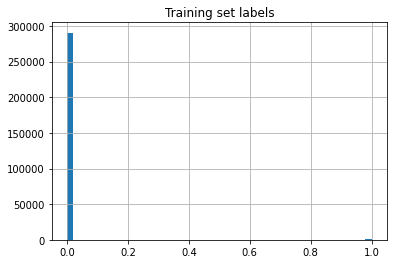

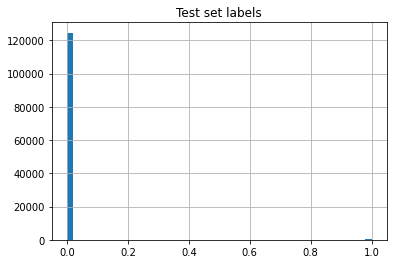

In [ ]:
# Observe the distribution of the labels.
plt.figure()
pd.Series(y).hist(bins=50)
plt.title("Training set labels")
plt.figure()
pd.Series(y_test).hist(bins=50)
plt.title("Test set labels")

**Scikit-Learn Decision Tree Classification**

[Text(243.4909090909091, 203.85, 'X[1] <= 119.5\ngini = 0.342\nsamples = 291423\nvalue = [2906.01, 813.78]'),
 Text(213.05454545454546, 176.67000000000002, 'gini = 0.0\nsamples = 289150\nvalue = [2891.5, 0.0]'),
 Text(273.92727272727274, 176.67000000000002, 'X[18] <= 0.5\ngini = 0.034\nsamples = 2273\nvalue = [14.51, 813.78]'),
 Text(243.4909090909091, 149.49, 'X[28] <= 1961826.5\ngini = 0.034\nsamples = 2260\nvalue = [14.38, 813.78]'),
 Text(213.05454545454546, 122.31, 'X[31] <= 561.0\ngini = 0.034\nsamples = 2248\nvalue = [14.26, 813.78]'),
 Text(152.1818181818182, 95.13, 'X[9] <= 0.5\ngini = 0.033\nsamples = 2208\nvalue = [13.87, 812.79]'),
 Text(121.74545454545455, 67.94999999999999, 'X[39] <= 0.5\ngini = 0.033\nsamples = 2201\nvalue = [13.8, 812.79]'),
 Text(60.872727272727275, 40.77000000000001, 'X[28] <= 1874573.5\ngini = 0.014\nsamples = 565\nvalue = [2.31, 330.66]'),
 Text(30.436363636363637, 13.590000000000003, 'gini = 0.013\nsamples = 559\nvalue = [2.25, 330.66]'),
 Text(91.

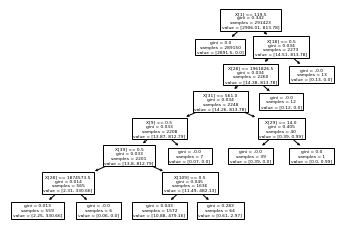

In [ ]:
# use decision tree
from sklearn import tree
dtree_clf = tree.DecisionTreeClassifier(max_depth=7, random_state=1555,class_weight={0:0.01,1:0.99})
dtree_clf.fit(x,y)

tree.plot_tree(dtree_clf) 
# dotfile = StringIO() 
# export_graphviz(dtree_reg, out_file=dotfile,feature_names=vectorizer.get_feature_names()) 
#pydotplus.graph_from_dot_data(dotfile.getvalue()).write_png("my_tree.png")    

# Export graph with time and date in filename. Added by JSP.
# import time
# timestr = time.strftime("%Y%m%d")
# pydotplus.graph_from_dot_data(dotfile.getvalue()).write_png(timestr + "_event_class_decision_tree.png")

In [ ]:
## Performance Measurement for Classification Tree. 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pandas import Series

#1. Resubstitution Error.
resuberror = accuracy_score(y, dtree_clf.predict(x)) 
print("resuberror= %0.4f" % (1- resuberror))

#2. Cross-Validation Error (Kfold = 10).
print("random_state = " + str(dtree_clf.random_state))
cverror = cross_val_score(dtree_clf, x, y,cv=10, scoring='accuracy')
print("cverror= %0.4f (+/- %0.4f)" % (1-cverror.mean(), cverror.std()))

# Generalization error.
testerror = accuracy_score(y_test, dtree_clf.predict(x_test))
print("testerror= %0.4f" % (1-testerror))
print('\nConfusion matrix for test set:') 
print(confusion_matrix(y_test, dtree_clf.predict(x_test)))
class_report = classification_report(y_test, dtree_clf.predict(x_test))
class_report = Series(class_report.splitlines()).str.rsplit(n= 4, expand=True).dropna()
class_report.columns = ['Class', 'precision', 'recall', 'f1-score', 'support']
class_report = class_report.reset_index()
del class_report['index']
print('\nClassification report for test set:')
print(class_report) 

# Computation time.
print('\nComputation time per sample:')
%timeit dtree_clf.predict(x_test[:1,:])

resuberror= 0.0047
random_state = 1555
cverror= 0.0047 (+/- 0.0012)
testerror= 0.0047

Confusion matrix for test set:
[[123971    574]
 [    13    348]]

Classification report for test set:
          Class precision recall f1-score support
0           0.0      1.00   1.00     1.00  124545
1           1.0      0.38   0.96     0.54     361
2     macro avg      0.69   0.98     0.77  124906
3  weighted avg      1.00   1.00     1.00  124906

Computation time per sample:
The slowest run took 7.06 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 87.7 µs per loop


In [ ]:
'''
Source: 
https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree
'''
def tree_to_rules(dt, all_features):
  tree_ = dt.tree_
  feature_names = [
                   all_features[i] if i != tree._tree.TREE_UNDEFINED else 'undefined' 
                   for i in tree_.feature
  ]

  def recurse(node, depth):
    indent = "- " * depth
    if tree_.feature[node] != tree._tree.TREE_UNDEFINED:
      name = feature_names[node]
      threshold = tree_.threshold[node]
      print(f"{indent}if {name} <= {threshold:.2f}:")
      recurse(tree_.children_left[node], depth + 1)
      print(f"{indent}else:  # if {name} > {threshold:.2f}")
      recurse(tree_.children_right[node], depth + 1)
    else:
      print(f"{indent}return >>> {tree_.value[node]}")

  recurse(0, 0)

tree_to_rules(dtree_clf, all_features)

if unavail_second <= 119.50:
- return >>> [[2891.50000002    0.        ]]
else:  # if unavail_second > 119.50
- if history_capacity <= 326.00:
- - return >>> [[  9.97 414.81]]
- else:  # if history_capacity > 326.00
- - return >>> [[  4.54 398.97]]



## Post-prunning

In [ ]:
## Finding best level for pruning.

pru_level = list(range(1,25))
pru_level.append(None)
cverror_vector = np.empty((len(pru_level),2),float)

#1. Print random seed.
print("random_state = " + str(dtree_clf.random_state))

#2. Grow the tree with different prunning levels and compute cross-validation error.
j = 0
for i in pru_level:
    dtree_clf = dtree_clf.set_params(max_depth = i, random_state=dtree_clf.random_state)
    cverror = cross_val_score(dtree_clf, x, y,cv=10, scoring='recall')
    cverror_vector[j,:] = [-cverror.mean(), cverror.std()]
    j = j+1
    if (type(i) == int):
        print("max_depth = %i \t\t-> cverror= %0.4f (+/- %0.4f)" % (i, cverror.mean(), cverror.std()))
    else:
        print("max_depth = Unlimited \t-> cverror= %0.4f (+/- %0.4f)" % (cverror.mean(), cverror.std()))

#3. Detect smallest tree within one standard error of the minimum crossvalidation error.
cv_error_vector_min = cverror_vector[:,0].min()
index_min_cverror = np.nonzero(cverror_vector[:,0] <= cv_error_vector_min) # Threshold with minimum error.
cv_error_vector_min = cv_error_vector_min + cverror_vector[index_min_cverror[0][0],1] # Increase tolerance of minimum error by one standard error.
index_min_cverror = np.nonzero(cverror_vector[:,0] <= cv_error_vector_min) # Threshold with new value.
BestLevel = pru_level[index_min_cverror[0][0]]
print("BestLevel = " + str(BestLevel))

random_state = 1555
max_depth = 1 		-> cverror= 1.0000 (+/- 0.0000)
max_depth = 2 		-> cverror= 1.0000 (+/- 0.0000)
max_depth = 3 		-> cverror= 1.0000 (+/- 0.0000)
max_depth = 4 		-> cverror= 1.0000 (+/- 0.0000)
max_depth = 5 		-> cverror= 1.0000 (+/- 0.0000)
max_depth = 6 		-> cverror= 1.0000 (+/- 0.0000)
max_depth = 7 		-> cverror= 1.0000 (+/- 0.0000)
max_depth = 8 		-> cverror= 1.0000 (+/- 0.0000)
max_depth = 9 		-> cverror= 1.0000 (+/- 0.0000)
max_depth = 10 		-> cverror= 1.0000 (+/- 0.0000)
max_depth = 11 		-> cverror= 1.0000 (+/- 0.0000)
max_depth = 12 		-> cverror= 1.0000 (+/- 0.0000)
max_depth = 13 		-> cverror= 1.0000 (+/- 0.0000)
max_depth = 14 		-> cverror= 1.0000 (+/- 0.0000)
max_depth = 15 		-> cverror= 1.0000 (+/- 0.0000)
max_depth = 16 		-> cverror= 1.0000 (+/- 0.0000)
max_depth = 17 		-> cverror= 1.0000 (+/- 0.0000)
max_depth = 18 		-> cverror= 1.0000 (+/- 0.0000)
max_depth = 19 		-> cverror= 1.0000 (+/- 0.0000)
max_depth = 20 		-> cverror= 1.0000 (+/- 0.0000)
max_depth

In [ ]:
pruned_tree_features = np.array(all_features)[dtree_clf.feature_importances_ > 0]
pruned_tree_features

array(['unavail_second', 'history_capacity'], dtype='<U53')

## Simplifying the Model

In [ ]:
to_keep = pruned_tree_features.tolist()
to_keep.append('rlf')

train_df = train_df.loc[:,to_keep]
test_df = test_df.loc[:,to_keep]

# Select the target
target = 'rlf'

In [ ]:
x = train_df.loc[:, train_df.columns != target].values
y = train_df.loc[:, train_df.columns == target].values.ravel()

x = np.array(x).astype(float)
y = np.array(y).astype(float)

x_test = test_df.loc[:, test_df.columns != target].values
y_test = test_df.loc[:, test_df.columns == target].values.ravel()

x_test = np.array(x_test).astype(float)
y_test = np.array(y_test).astype(float)

In [ ]:
# use decision tree
dtree_clf = tree.DecisionTreeClassifier(max_depth=7, random_state=1555,class_weight={0:0.001,1:0.001})
dtree_clf.fit(x,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 0.001, 1: 1e-05},
                       criterion='gini', max_depth=7, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=1555,
                       splitter='best')

In [ ]:
## Performance Measurement for Classification Tree. 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pandas import Series

# Generalization error.
testerror = accuracy_score(y_test, dtree_clf.predict(x_test))
print("testerror= %0.4f" % (1-testerror))
print('\nConfusion matrix for test set:') 
print(confusion_matrix(y_test, dtree_clf.predict(x_test)))
class_report = classification_report(y_test, dtree_clf.predict(x_test))
class_report = Series(class_report.splitlines()).str.rsplit(n= 4, expand=True).dropna()
class_report.columns = ['Class', 'precision', 'recall', 'f1-score', 'support']
class_report = class_report.reset_index()
del class_report['index']
print('\nClassification report for test set:')
print(class_report) 

# Computation time.
print('\nComputation time per sample:')
%timeit dtree_clf.predict(x_test[:1,:])

testerror= 0.0022

Confusion matrix for test set:
[[124417    128]
 [   151    210]]

Classification report for test set:
          Class precision recall f1-score support
0           0.0      1.00   1.00     1.00  124545
1           1.0      0.62   0.58     0.60     361
2     macro avg      0.81   0.79     0.80  124906
3  weighted avg      1.00   1.00     1.00  124906

Computation time per sample:
The slowest run took 4.11 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 88.2 µs per loop


# **Random forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

In [ ]:
%%time
classifier_rf.fit(X_train, y_train)

CPU times: user 31.4 s, sys: 288 ms, total: 31.7 s
Wall time: 20.4 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
classifier_rf.oob_score_

0.9971793578406646

In [ ]:
y_pred_test = classifier_rf.predict(x_test)

In [ ]:
# View accuracy score
accuracy_score(y_test, y_pred_test)

0.9971098265895953

In [ ]:
confusion_matrix(y_test, y_pred_test)

array([[124545,      0],
       [   361,      0]])

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    124545
         1.0       0.00      0.00      0.00       361

    accuracy                           1.00    124906
   macro avg       0.50      0.50      0.50    124906
weighted avg       0.99      1.00      1.00    124906



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("F1 Score for Balanced Random Forest Classifier is ", f1_score(y_test,brfc.predict(x_test)))

In [ ]:
https://towardsdatascience.com/4-unique-approaches-to-manage-imbalance-classification-scenario-7c5b92637b9c

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(x, y)
print("Number of records for X_train is ", x.shape)
print("Number of records for X_resampled undersampling is ",X_resampled.shape)

Number of records for X_train is  (291423, 122)
Number of records for X_resampled undersampling is  (1644, 122)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
uclf=RandomForestClassifier(max_depth=2,random_state=0).fit(X_resampled, y_resampled)

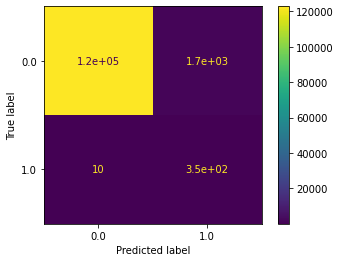

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig=plot_confusion_matrix(uclf, x_test, y_test)
plt.show()

In [ ]:
y_pred_test = uclf.predict(x_test)
# View accuracy score
accuracy_score(y_test, y_pred_test)

0.9859814580564584

In [ ]:
confusion_matrix(y_test, y_pred_test)

array([[122804,   1741],
       [    10,    351]])

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    124545
         1.0       0.17      0.97      0.29       361

    accuracy                           0.99    124906
   macro avg       0.58      0.98      0.64    124906
weighted avg       1.00      0.99      0.99    124906



In [ ]:
import sklearn
from sklearn.metrics import fbeta_score

In [ ]:
sklearn.metrics.fbeta_score(y_test,y_pred_test,beta=1.0,average='weighted')

0.9908786156261815

In [ ]:
sklearn.metrics.fbeta_score(y_test,y_pred_test,beta=1.0)

0.28618018752547897